In [1]:
%pylab inline
from analysis_toolbox import *
from qualityBaseline import *
import pandas as pd 
from scipy.optimize import minimize
bb_info = pd.read_csv('../../crowd-seg/analysis/computed_my_COCO_BBvals.csv')
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
object_id_lst  = list(set(obj_sorted_tbl.object_id))
img_info,object_tbl,bb_info,hit_info = load_info()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def abslogN(param):
    '''
    Drawing from normal distribution with prior (std) as param, with mean centered at 0
    log without nan; nan if value <0
    '''
    return log(abs(random.normal(0,param)))
def compute_phii(metric):
    '''
    phi value compared to ground truth 
    '''
    if metric in ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]",\
       'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]"]:
        return 1
    elif metric in ["Num Points","Area Ratio"]:
        return 0

In [27]:
# T = total number of tasks
# n = number of points in bounding box
# m = number of metric functions of interest
# W = total number of workers 
#metric functions of interest 
#metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
#               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
metrics_lst = ['Precision [COCO]','Recall [COCO]']
worker_lst = unique(bb_info.worker_id)
#Parameters: Priors
beta,gamma,theta = [1,1,1]
# Hidden variables 
m = len(metrics_lst)
T = len(img_info)
W = len(worker_lst)
z = np.ones((50,T))# n x T
D = np.zeros((m,T))# m x T
b = np.zeros((m,W))# m x W
c = np.zeros((m,W))# m x W
# equally weigh Di and cj
w1=0.5
w2=0.5

In [29]:
def Q(params):
    beta,gamma,theta = params
    loglikelihood=[]
    # Loop through all Phi metrics 
    for k in range(m):
        #Loop through all task
        logpD_lst =[]
        for j in range(W):
            logpD_lst.append(abslogN(theta))
        logpD =sum(logpD_lst)
        #Loop through all workers
        worker_quality_prob=[]
        for i in range(T):
            worker_quality_prob.append(abslogN(beta)+ abslogN(gamma))
            logphiij_lst = []
            # Ji is the list of workers that annotated object i
            Ji = list(obj_sorted_tbl[obj_sorted_tbl["object_id"]==i].worker_id)
            for j in Ji : 
                j = int(np.where(worker_lst==j)[0])
                phii=compute_phii(metrics_lst[k])
                mu = phii-b[k][j]
                sig = sqrt(w1*D[k][i]**2+w2*c[k][j]**2)
                if sig==0: sig=1e-5
                logphiij_lst.append(log(abs(random.normal(mu,sig))))
        logphiij = sum(logphiij_lst)
        loglikelihood.append(sum(worker_quality_prob)+logphiij+logpD)
    # sum of likelihood over all the Phi_k functions 
    return -sum(loglikelihood)

In the M step you maximize the posterior by minimizing the -log likelihood. Then using the maximized parameters $\theta^\prime$, update hidden var Di,bj,cj, by drawing your distribution based on those maximized parameters. zi will not be updated.

In [25]:
Q([beta,gamma,theta])

306.01358064382237

In [9]:
bnds= ((0, None), (0, None),(0, None))
results = minimize(Q,[200,200,200],method='tnc',bounds=bnds)#, options={'factr' : 1e7})

In [10]:
results

     fun: -1022.1637989726872
     jac: array([ -2.58093526e+09,  -2.42682874e+09,  -2.99862097e+09])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 5
     nit: 1
  status: 2
 success: True
       x: array([ 199.99999989,  200.00000157,  200.00000095])

this is a bit weird because the optimized parameters are always very close to the initial conditions 

In [13]:
bnds= ((0, None), (0, None),(0, None))
N_iter = 50 #numebr of iterations 
negloglikelihood_lst = []
for i in range(N_iter): 
    print ""
    # E step 
    negloglikelihood = Q([beta,gamma,theta])
    negloglikelihood_lst.append(negloglikelihood)
    # M step
    results = minimize(Q,[200,200,200],method='tnc',bounds=bnds)#, options={'factr' : 1e7})
    beta,gamma,theta = results.x

In [18]:
results

     fun: -1022.3961879225614
     jac: array([  5.82187234e+09,   2.77439877e+09,   4.41009234e+09])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 4
     nit: 1
  status: 2
 success: True
       x: array([ 200.00000011,  200.00000012,  200.00000021])

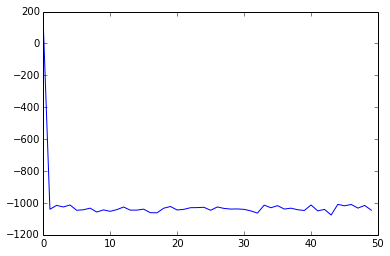

In [17]:
plt.plot(negloglikelihood_lst)

The problem is that since the parameters are all nearby after the minimization step, the log likelihood doesn't really go down very far and what should happen for EM is that the loglikelihood should decrease monotonically. But: 
- does EM require that Q must be convex in order to converge?? 

We want to separate out Qk so that we are doing EM on each metric function component of Phi separately. 

In [35]:
# T = total number of tasks
# n = number of points in bounding box
# m = number of metric functions of interest
# W = total number of workers 
#metric functions of interest 
#metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
#               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
metrics_lst = ['Precision [COCO]','Recall [COCO]']
worker_lst = unique(bb_info.worker_id)
#Parameters: Priors
beta_vec = np.ones((m,1))# m x 1
gamma_vec = np.ones((m,1))# m x 1
theta_vec = np.ones((m,1))# m x 1
# Hidden variables 
m = len(metrics_lst)
T = len(img_info)
W = len(worker_lst)
z = np.ones((50,T))# n x T
D = np.zeros((m,T))# m x T
b = np.zeros((m,W))# m x W
c = np.zeros((m,W))# m x W
# equally weigh Di and cj
w1=0.5
w2=0.5

In [36]:
def Q_k(params,k):
    beta,gamma,theta = params
    loglikelihood=[]
    #Loop through all task
    logpD_lst =[]
    for j in range(W):
        logpD_lst.append(abslogN(theta))
    logpD =sum(logpD_lst)
    #Loop through all workers
    worker_quality_prob=[]
    for i in range(T):
        worker_quality_prob.append(abslogN(beta)+ abslogN(gamma))
        logphiij_lst = []
        # Ji is the list of workers that annotated object i
        Ji = list(obj_sorted_tbl[obj_sorted_tbl["object_id"]==i].worker_id)
        for j in Ji : 
            j = int(np.where(worker_lst==j)[0])
            phii=compute_phii(metrics_lst[k])
            mu = phii-b[k][j]
            sig = sqrt(w1*D[k][i]**2+w2*c[k][j]**2)
            if sig==0: sig=1e-5
            logphiij_lst.append(log(abs(random.normal(mu,sig))))
    logphiij = sum(logphiij_lst)
    loglikelihood.append(sum(worker_quality_prob)+logphiij+logpD)
    # sum of likelihood over all the Phi_k functions 
    return -sum(loglikelihood)

In [43]:
bnds= ((0, None), (0, None),(0, None))
N_iter = 50 #numebr of iterations 
negloglikelihood_lst = []
# Loop through all Phi metrics 
for k in range(m):
    negloglikelihood_klst=[]
    for i in range(N_iter): 
        # E step 
        negloglikelihood = Q_k([beta,gamma,theta],k)
        negloglikelihood_klst.append(negloglikelihood)
        # M step
        results = minimize(Q_k,[100,100,100],args=(k),method='tnc',bounds=bnds)#, options={'factr' : 1e7})
        beta,gamma,theta = results.x
        beta_vec[k]=beta
        gamma_vec[k]=gamma
        theta_vec[k]=theta
        print '------------'
        print "{0} iter".format(i)
        print "likelihood: {0}".format(negloglikelihood)
        print "[b,g,t]: {0},{1},{2}".format(beta,gamma,theta)
    negloglikelihood_lst.append(negloglikelihood_klst)

------------
0 iter
likelihood: -867.397818058
[b,g,t]: 99.9999993254,99.9999997387,99.9999995541
------------
1 iter
likelihood: -891.268454034
[b,g,t]: 100.000000057,100.000000062,100.000000017
------------
2 iter
likelihood: -863.363812744
[b,g,t]: 99.9999999907,100.000000168,100.000000213
------------
3 iter
likelihood: -909.330033626
[b,g,t]: 99.9999991758,99.9999997197,99.999999751
------------
4 iter
likelihood: -871.530866562
[b,g,t]: 99.9999999989,100.0,99.9999999914
------------
5 iter
likelihood: -875.784391546
[b,g,t]: 100.000001106,100.000000412,100.000000673
------------
6 iter
likelihood: -868.468526636
[b,g,t]: 100.00000023,100.000000196,100.000000204
------------
7 iter
likelihood: -894.41695213
[b,g,t]: 100.000001581,100.000001933,100.000001984
------------
8 iter
likelihood: -878.748704979
[b,g,t]: 100.000000002,99.9999999999,100.000000001
------------
9 iter
likelihood: -884.769799802
[b,g,t]: 100.000000004,99.9999999874,100.000000002
------------
10 iter
likelihood

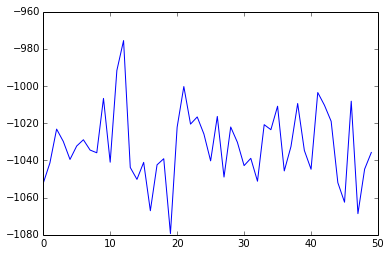

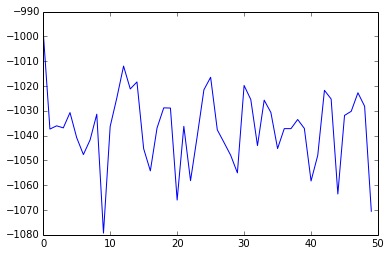

In [41]:
for negloglikelihood_klst in negloglikelihood_lst:
    plt.figure()
    plt.plot(negloglikelihood_klst)

There's a mistake in the equation when I took out the summation for Q_k, the correct version of Q_k is this: 
$$ Q_k(\mathbf{\Theta}|\mathbf{\Theta}^\prime)= \sum_j \Bigg[ log p(b_j|\beta_k)+  log p(c_j|\gamma_k)\Bigg] + \sum_i \Bigg[\sum_{j\in J_i}  log p(D_i|\theta_k) + log \mathcal{N}(\phi_{ij};\mu_{ij},\sigma_{ij}) \Bigg]$$

In [65]:
# T = total number of tasks
# n = number of points in bounding box
# m = number of metric functions of interest
# W = total number of workers 
#metric functions of interest 
#metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
#               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
metrics_lst = ['Precision [COCO]','Recall [COCO]']
worker_lst = unique(bb_info.worker_id)
#Parameters: Priors
beta_vec = np.ones((m,1))# m x 1
gamma_vec = np.ones((m,1))# m x 1
theta_vec = np.ones((m,1))# m x 1
# Hidden variables 
m = len(metrics_lst)
T = len(img_info)
W = len(worker_lst)
z = np.ones((50,T))# n x T
D = np.zeros((m,T))# m x T
b = np.zeros((m,W))# m x W
c = np.zeros((m,W))# m x W
# equally weigh Di and cj
w1=0.5
w2=0.5

In [66]:
def Q_k(params,k):
    beta,gamma,theta = params
    loglikelihood=[]
    #Loop through all task
    task_prob_lst =[]
    for i in range(T):
        logphiij_lst = []
        # Ji is the list of workers that annotated object i
        Ji = list(obj_sorted_tbl[obj_sorted_tbl["object_id"]==i].worker_id)
        Di = abslogN(theta)
        # Updating Di
        D[k][i]=Di
        for j in Ji : 
            j = int(np.where(worker_lst==j)[0])
            phii=compute_phii(metrics_lst[k])
            mu = phii-b[k][j]
            cj = abslogN(gamma)
            sig = sqrt(w1*Di**2+w2*cj**2)
            if sig==0: sig=1e-5
            logphiij_lst.append(log(abs(random.normal(mu,sig))))
        logphiij = sum(logphiij_lst)
        task_prob_lst.append(Di+logphiij)
    task_prob = sum(task_prob_lst)

    #Loop through all workers
    worker_prob_lst=[]
    for j in range(W):
        bj = abslogN(beta)
        cj = abslogN(gamma)
        worker_prob_lst.append(bj+cj)
        # Updating cj,bj
        b[k][j] = bj
        c[k][j] = cj
    worker_prob= sum(worker_prob_lst)
    loglikelihood.append(worker_prob+task_prob)
    # Updating parameter vectors 
    beta_vec[k] = beta
    gamma_vec[k] = gamma
    theta_vec[k] = theta

    # sum of likelihood over all the Phi_k functions 
    return -sum(loglikelihood)

In [67]:
bnds= ((0, None), (0, None),(0, None))
N_iter = 50 #numebr of iterations 
negloglikelihood_lst = []
# Loop through all Phi metrics 
for k in range(m):
    negloglikelihood_klst=[]
    for i in range(N_iter): 
        # E step 
        negloglikelihood = Q_k([beta,gamma,theta],k)
        negloglikelihood_klst.append(negloglikelihood)
        # M step
        results = minimize(Q_k,[100,100,100],args=(k),method='tnc',bounds=bnds)#, options={'factr' : 1e7})
        beta,gamma,theta = results.x
        beta_vec[k]=beta
        gamma_vec[k]=gamma
        theta_vec[k]=theta
        print '------------'
        print "{0} iter".format(i)
        print "likelihood: {0}".format(negloglikelihood)
        print "[b,g,t]: {0},{1},{2}".format(beta,gamma,theta)
    negloglikelihood_lst.append(negloglikelihood_klst)

------------
0 iter
likelihood: -1747.88645419
[b,g,t]: 99.9999999668,99.9999999633,99.9999999553
------------
1 iter
likelihood: -1779.9868979
[b,g,t]: 100.000000338,100.000000102,100.000000253
------------
2 iter
likelihood: -1764.32651206
[b,g,t]: 100.000000157,100.000000104,100.000000051
------------
3 iter
likelihood: -1774.44565161
[b,g,t]: 99.9999999958,100.000000151,99.9999999828
------------
4 iter
likelihood: -1804.90512516
[b,g,t]: 100.000000003,100.0,100.000000009
------------
5 iter
likelihood: -1832.58612733
[b,g,t]: 100.000003032,99.9999958051,100.000001847
------------
6 iter
likelihood: -1785.29739899
[b,g,t]: 100.000000064,99.9999998294,99.9999996804
------------
7 iter
likelihood: -1811.90606244
[b,g,t]: 99.9999997984,99.9999998213,99.9999995631
------------
8 iter
likelihood: -1802.5338005
[b,g,t]: 99.9999999249,99.999999923,99.999999795
------------
9 iter
likelihood: -1775.65622542
[b,g,t]: 99.9999998202,99.9999996271,99.9999998317
------------
10 iter
likelihood:

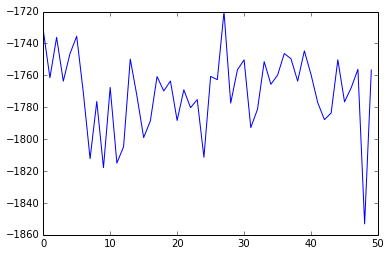

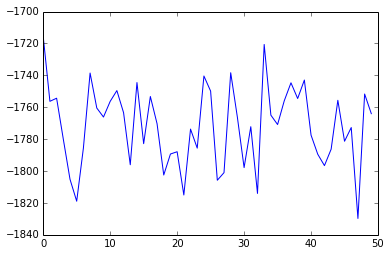

In [56]:
for negloglikelihood_klst in negloglikelihood_lst:
    plt.figure()
    plt.plot(negloglikelihood_klst)

In [59]:
def constant_gamma(gamma,type='contour',xlim =[1,100],ylim=[1,100]):
    xlist = np.linspace(xlim[0],xlim[1])
    ylist = np.linspace(ylim[0],ylim[1])
    X, Y = np.meshgrid(xlist, ylist)
    Z = []
    for x in xlist:
        tmp = []
        for y in ylist:
            tmp.append(Q([x,gamma,y]))
        Z.append(tmp)

    plt.figure()
    if type=='contour':
        cp = plt.contourf(X, Y, Z)
    elif type =='heatmap' :
        cp = plt.imshow(Z,interpolation="none",extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.colorbar(cp)
    plt.title("gamma = {}".format(gamma))
    plt.xlabel("beta")
    plt.ylabel("theta")
    plt.show()

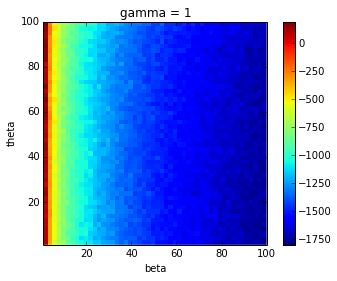

In [60]:
constant_gamma(1,'heatmap')

In [61]:
def constant_beta(beta,type='contour'):
    xlist = np.linspace(1,100)
    ylist = np.linspace(1,100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = []
    for x in xlist:
        tmp = []
        for y in ylist:
            tmp.append(Q([beta,x,y]))
        Z.append(tmp)

    plt.figure()
    if type=='contour':
        cp = plt.contourf(X, Y, Z)
    elif type =='heatmap' :
        cp = plt.imshow(Z,interpolation="none",extent=[1,100,1,100])
    plt.colorbar(cp)
    plt.title("beta = {}".format(beta))
    plt.xlabel("gamma")
    plt.ylabel("theta")
    plt.show()

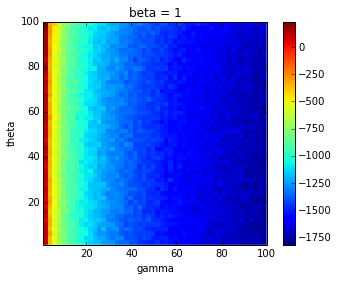

In [62]:
constant_beta(1,'heatmap')

In [63]:
def constant_theta(z,type='contour'):
    xlist = np.linspace(1,100)
    ylist = np.linspace(1,100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = []
    for x in xlist:
        tmp = []
        for y in ylist:
            tmp.append(Q([x,y,z]))
        Z.append(tmp)

    plt.figure()
    if type=='contour':
        cp = plt.contourf(X, Y, Z)
    elif type =='heatmap' :
        cp = plt.imshow(Z,interpolation="none",extent=[1,100,1,100])
    plt.colorbar(cp)
    plt.title("theta = {}".format(z))
    plt.xlabel("beta")
    plt.ylabel("gamma")
    plt.show()

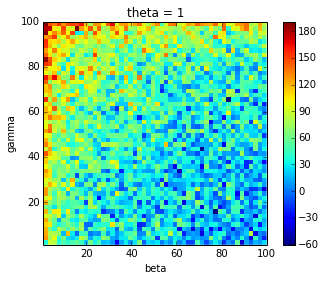

In [64]:
constant_theta(1,'heatmap')